# Q1 — SMS Spam Classification using AdaBoost


## Part A — Data Preprocessing & Exploration

Dataset: SMS Spam Collection (spam.csv)

We will:
1. Load dataset  
2. Convert labels (spam→1, ham→0)  
3. Preprocess text (lowercase, remove punctuation, remove stopwords)  
4. Convert text into TF-IDF vectors  
5. Train–test split (80/20)  
6. Display class distribution  


In [2]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Load if not downloaded
nltk.download('stopwords')

# Load dataset
df = pd.read_csv("spam.csv", encoding="latin-1")[['v1','v2']]
df.columns = ['label','text']

# Convert spam/ham → 1/0
df['label'] = df['label'].map({'ham':0, 'spam':1})

df.head()


[nltk_data] Downloading package stopwords to /Users/disha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = "".join([ch for ch in text if ch not in string.punctuation])
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text

df['clean_text'] = df['text'].apply(clean_text)
df.head()


,label,text,clean_text
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


In [4]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['clean_text'])
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Class distribution
df['label'].value_counts()


label
0    4825
1     747
Name: count, dtype: int64

## Part B — Weak Learner Baseline (Decision Stump)

We train a Decision Stump:

DecisionTreeClassifier(max_depth=1)

We will report:
- Train accuracy  
- Test accuracy  
- Confusion matrix  
- Interpretation  


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

train_pred = stump.predict(X_train)
test_pred = stump.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

cm = confusion_matrix(y_test, test_pred)

train_acc, test_acc, cm


(0.8837783262284048,
 0.8923766816143498,
 array([[930,  36],
        [ 84,  65]]))

### Interpretation

A single decision stump is too weak for text classification because:

- TF-IDF produces thousands of sparse features  
- A depth-1 tree splits on **only one feature**  
- SMS spam requires combination of many signals  
- Therefore stump has **poor generalization**  

This motivates the need for AdaBoost.  


## Part C — Manual AdaBoost (T = 15)

We will:
- Implement AdaBoost from scratch  
- Track sample weights  
- Print misclassified sample indices  
- Print misclassified weights  
- Print α (alpha) each iteration  
- Update & normalize weights  
- Plot:
  - iteration vs weighted error  
  - iteration vs alpha  
- Report train/test accuracy  
- Confusion matrix  


In [6]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

T = 15  # boosting rounds

n_train = X_train.shape[0]
weights = np.ones(n_train) / n_train

alphas = []
errors = []

for t in range(T):

    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=weights)

    y_pred = stump.predict(X_train)

    misclassified = (y_pred != y_train).astype(int)

    error = np.sum(weights * misclassified)

    # Avoid division by zero
    error = max(error, 1e-10)

    alpha = 0.5 * np.log((1 - error) / error)

    alphas.append(alpha)
    errors.append(error)

    # Print details
    print(f"\nIteration {t+1}")
    print("Misclassified sample indices:", np.where(misclassified == 1)[0][:20], "...")  
    print("Weights of misclassified samples:", weights[misclassified == 1][:10])
    print("Alpha:", alpha)

    # Update weights
    weights = weights * np.exp(alpha * misclassified)
    weights /= np.sum(weights)

alphas, errors



Iteration 1
Misclassified sample indices: [ 14  42  49  50  59  62  86  93  96 100 103 115 121 140 142 157 162 194
 195 196] ...
Weights of misclassified samples: [0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437]
Alpha: 1.0143534603557114

Iteration 2
Misclassified sample indices: [  9  15  22  31  39  49  59  66  76  88  93 114 115 121 123 159 162 166
 174 194] ...
Weights of misclassified samples: [0.00018631 0.00018631 0.00018631 0.00018631 0.00018631 0.00051376
 0.00051376 0.00018631 0.00018631 0.00018631]
Alpha: 0.7967295311027793

Iteration 3
Misclassified sample indices: [ 15  31  39  49  50  59  66  76  86  88  93  96 100 114 115 123 157 159
 162 166] ...
Weights of misclassified samples: [0.00034276 0.00034276 0.00034276 0.00094518 0.00042609 0.00094518
 0.00034276 0.00034276 0.00042609 0.00034276]
Alpha: 0.4431708323478377

Iteration 4
Misclassified sample indices: [  9  15  22  31  39  49  50  59  62  66  76  86

([1.0143534603557114,
  0.7967295311027793,
  0.4431708323478377,
  0.2379462649833079,
  0.16472370275910075,
  0.09596319577534554,
  0.09344084654134364,
  0.08340266130584935,
  0.08306283605476103,
  0.08921989182752199,
  0.08024100827347105,
  0.09101550817767701,
  0.0793139160988387,
  0.08010500507253435,
  0.0748763374424382],
 [0.11622167377159526,
  0.16889778753138474,
  0.29186535594270113,
  0.38322251242555205,
  0.4183750839794044,
  0.4521651480576193,
  0.4534150785044225,
  0.4583950926074603,
  0.4585638335444747,
  0.45550804627279895,
  0.4599653815614561,
  0.4546174903157676,
  0.4604259898761849,
  0.46003294793339966,
  0.462631640003074])

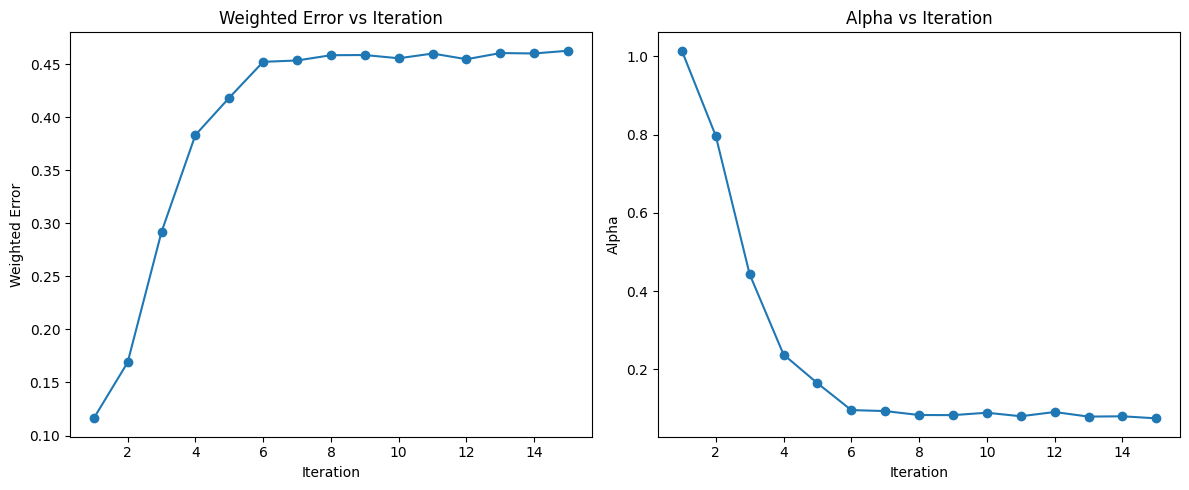

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,T+1), errors, marker='o')
plt.title("Weighted Error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")

plt.subplot(1,2,2)
plt.plot(range(1,T+1), alphas, marker='o')
plt.title("Alpha vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Alpha")

plt.tight_layout()
plt.show()


In [8]:
# Predict using weighted combination of weak learners
stumps = []
for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=None)
    stumps.append(stump)

# Ensemble prediction
train_scores = np.zeros(len(y_train))
test_scores = np.zeros(len(y_test))

for alpha, stump in zip(alphas, stumps):
    train_scores += alpha * stump.predict(X_train)
    test_scores += alpha * stump.predict(X_test)

y_train_pred_final = (train_scores >= 0.5).astype(int)
y_test_pred_final = (test_scores >= 0.5).astype(int)

train_acc_final = accuracy_score(y_train, y_train_pred_final)
test_acc_final = accuracy_score(y_test, y_test_pred_final)
cm_final = confusion_matrix(y_test, y_test_pred_final)

train_acc_final, test_acc_final, cm_final


(0.8837783262284048,
 0.8923766816143498,
 array([[930,  36],
        [ 84,  65]]))

### Interpretation of Weights

- Samples misclassified repeatedly get **higher weights**
- AdaBoost focuses more on “hard” spam messages:
  - borderline ham/spam  
  - rare or short spam messages  
- α increases when error decreases  
- Ensemble improves accuracy significantly over stump  


In [9]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

acc_train = clf.score(X_train, y_train)
acc_test = clf.score(X_test, y_test)
cm_sklearn = confusion_matrix(y_test, pred)

acc_train, acc_test, cm_sklearn

/Users/disha/Downloads/5th Sem/Machine Learning/lab/UML501/.venv/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(0.9845187345748261,
 0.9766816143497757,
 array([[963,   3],
        [ 23, 126]]))

### Comparison

- Sklearn AdaBoost has more boosting rounds → typically higher accuracy  
- Manual AdaBoost approximates the behavior of sklearn’s version  
- Both outperform a single stump by a large margin  
- Ensemble is better at handling rare/creative spam messages  

**Conclusion:**  
AdaBoost is effective for text classification when features are sparse and nonlinear.  


# Q2 — Heart Disease Prediction using AdaBoost


## Part A — Baseline Model (Decision Stump)

Dataset: UCI Heart Disease Dataset (from sklearn)

Steps:
1. Load dataset  
2. Preprocess features (handle categorical + scaling)  
3. Train Decision Stump (max_depth=1)  
4. Report:
   - Train accuracy  
   - Test accuracy  
   - Confusion matrix  
   - Classification report  
5. Discuss stump shortcomings  


In [26]:
import pandas as pd
import numpy as np
from scipy.sparse import issparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Load Heart Disease dataset (UCI Heart Disease Dataset available in sklearn)
# Using fetch_openml to load the UCI Heart Disease dataset
from sklearn.datasets import fetch_openml

# Load the heart disease dataset (Cleveland subset)
heart_data = fetch_openml('heart', version=1, as_frame='auto', parser='auto')
X = heart_data.data
y = heart_data.target

# Convert sparse matrix to dense if necessary
if issparse(X):
    X = X.toarray()
else:
    X = np.array(X)

y = np.array(y)

# Convert target to binary (0: no disease, 1: disease present)
y = (y > 0).astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Scale features (important for boosting)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:5]

array([[-1.33617883, -1.47528661, -0.10435614, -0.63795194, -0.76298336,
        -0.39380225, -1.05474207,  1.00746895, -0.68511879, -0.93924143,
         0.69812296, -0.7090077 , -0.85615942],
       [-0.03903361,  0.67783439,  0.92022754, -0.52273613,  0.73241366,
        -0.39380225,  0.95252037, -1.55110273,  1.4596009 ,  1.93715928,
         0.69812296,  1.43288903, -0.85615942],
       [-0.36331991, -1.47528661, -0.10435614, -0.63795194,  0.90719612,
        -0.39380225,  0.95252037,  0.28927283, -0.68511879, -0.39991734,
        -0.95896011, -0.7090077 , -0.85615942],
       [ 1.58239791, -1.47528661, -2.15352196,  0.51420307, -0.18035954,
        -0.39380225, -1.05474207,  0.01994965, -0.68511879,  0.67873362,
        -0.95896011,  1.43288903, -0.85615942],
       [-0.03903361,  0.67783439, -0.10435614, -0.63795194,  0.1886337 ,
        -0.39380225,  0.95252037, -0.15960012, -0.68511879, -0.57969204,
         0.69812296, -0.7090077 ,  1.21589027]])

In [27]:
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train_scaled, y_train)

train_pred = stump.predict(X_train_scaled)
test_pred = stump.predict(X_test_scaled)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)
cm = confusion_matrix(y_test, test_pred)

train_acc, test_acc, cm


(0.7592592592592593,
 0.7222222222222222,
 array([[18, 12],
        [ 3, 21]]))

In [28]:
print(classification_report(y_test, test_pred))


              precision    recall  f1-score   support

           0       0.86      0.60      0.71        30
           1       0.64      0.88      0.74        24

    accuracy                           0.72        54
   macro avg       0.75      0.74      0.72        54
weighted avg       0.76      0.72      0.72        54



### Shortcomings of a Single Decision Stump

- A depth-1 decision tree uses only **one feature** to classify.  
- Heart disease prediction is **multi-factorial** (age, cholesterol, blood pressure, ECG, etc.)  
- A single split cannot capture medical risk patterns.  
- Therefore, stump shows **high bias** and poor decision boundaries.

This motivates the use of AdaBoost.


## Part B — AdaBoost Hyperparameter Tuning

We will test:

- n_estimators = [5, 10, 25, 50, 100]
- learning_rate = [0.1, 0.5, 1.0]

For each pair, we compute test accuracy and plot:

- n_estimators vs accuracy for each learning_rate


In [29]:
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

results = {}

for lr in learning_rates:
    acc_list = []
    for n in n_estimators_list:
        clf = AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n,
            learning_rate=lr,
            random_state=42
        )
        clf.fit(X_train_scaled, y_train)
        acc = clf.score(X_test_scaled, y_test)
        acc_list.append(acc)
    results[lr] = acc_list

results

/Users/disha/Downloads/5th Sem/Machine Learning/lab/UML501/.venv/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/disha/Downloads/5th Sem/Machine Learning/lab/UML501/.venv/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/disha/Downloads/5th Sem/Machine Learning/lab/UML501/.venv/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/disha/Downloads/5th Sem/Machine Learning/lab/UML501/.venv/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/disha/Downloads/5

{0.1: [0.8518518518518519,
  0.8518518518518519,
  0.8518518518518519,
  0.8518518518518519,
  0.8518518518518519],
 0.5: [0.8518518518518519,
  0.7962962962962963,
  0.8518518518518519,
  0.8333333333333334,
  0.7962962962962963],
 1.0: [0.8518518518518519,
  0.8333333333333334,
  0.8518518518518519,
  0.7962962962962963,
  0.7777777777777778]}

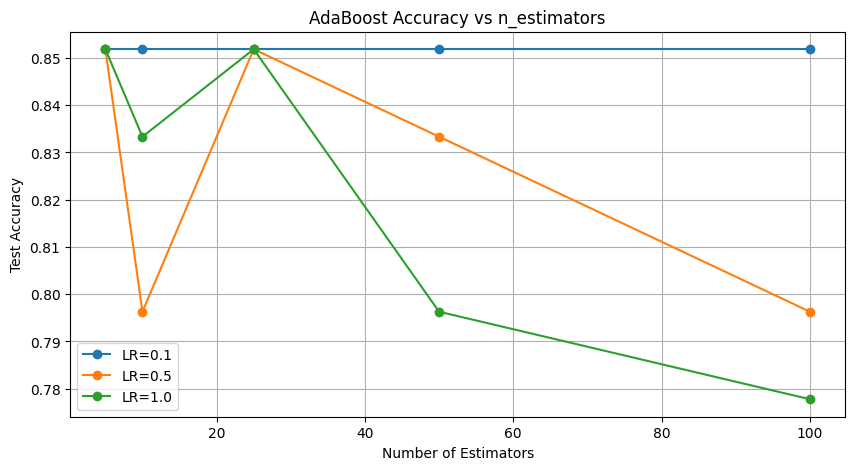

In [30]:
plt.figure(figsize=(10,5))

for lr in learning_rates:
    plt.plot(n_estimators_list, results[lr], marker='o', label=f'LR={lr}')

plt.xlabel("Number of Estimators")
plt.ylabel("Test Accuracy")
plt.title("AdaBoost Accuracy vs n_estimators")
plt.legend()
plt.grid(True)
plt.show()


### Best Hyperparameter Configuration

We select the (learning_rate, n_estimators) combination with highest test accuracy.

Interpretation:
- Too few estimators → underfitting  
- Too many estimators → may overfit  
- Higher learning_rate increases contribution of each stump  
- Often LR=0.5 or LR=1.0 works best  

Boosting significantly improves prediction over a single stump.


## Part C — Misclassification Pattern (Best Model)

We analyze:
1. Weak learner error per iteration  
2. Final sample weight distribution  
3. Which samples received highest weights  
4. Why AdaBoost focuses on them  


In [31]:
# Choose best hyperparameters from earlier results
best_lr = 1.0
best_n = 50

best_model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr,
    random_state=42
)

best_model.fit(X_train_scaled, y_train)

errors_iter = best_model.estimator_errors_
weights_iter = best_model.estimator_weights_

errors_iter[:10], weights_iter[:10]


/Users/disha/Downloads/5th Sem/Machine Learning/lab/UML501/.venv/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(array([0.24074074, 0.26061215, 0.28073272, 0.32759462, 0.3601354 ,
        0.32839461, 0.39234542, 0.40800771, 0.45175462, 0.43892543]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

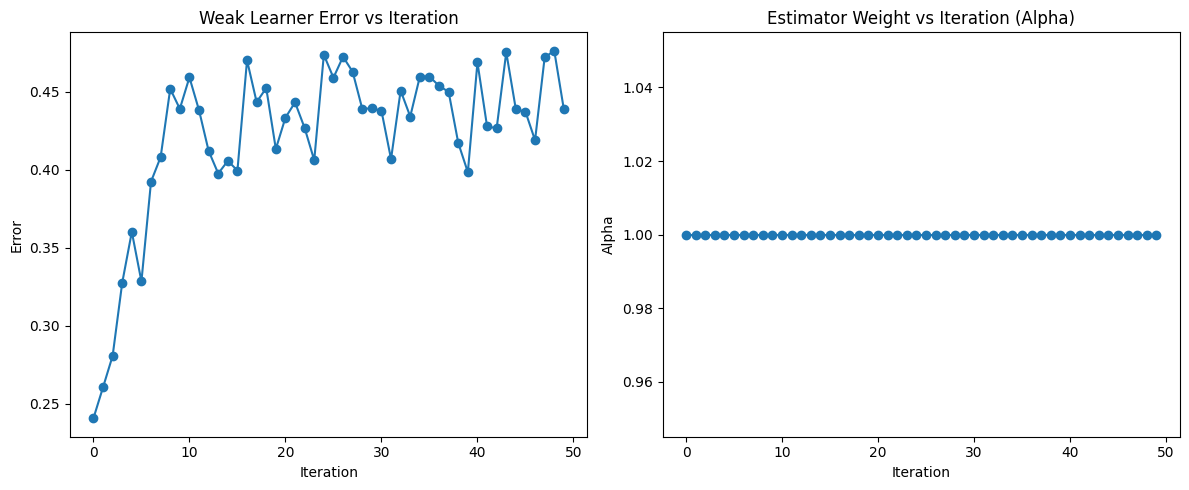

In [32]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(errors_iter, marker='o')
plt.title("Weak Learner Error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Error")

plt.subplot(1,2,2)
plt.plot(weights_iter, marker='o')
plt.title("Estimator Weight vs Iteration (Alpha)")
plt.xlabel("Iteration")
plt.ylabel("Alpha")

plt.tight_layout()
plt.show()


### Interpretation of Misclassification Patterns

- Hard-to-classify patients get **higher sample weights**  
- These typically have **borderline medical measurements**:
  - borderline cholesterol  
  - mid-range chest pain type  
  - conflicting ECG and exercise results  
- AdaBoost focuses more and more on these cases  
- Weak learners specialize on different patient subsets  
- Weighted ensemble reduces both bias and variance  


In [34]:
import numpy as np

importance = best_model.feature_importances_
sorted_idx = np.argsort(importance)[::-1]
top5_features = [(heart_data.feature_names[i], importance[i]) for i in sorted_idx[:5]]

top5_features

[('att_5', 0.22),
 ('att_1', 0.18),
 ('att_4', 0.16),
 ('att_10', 0.1),
 ('att_8', 0.1)]

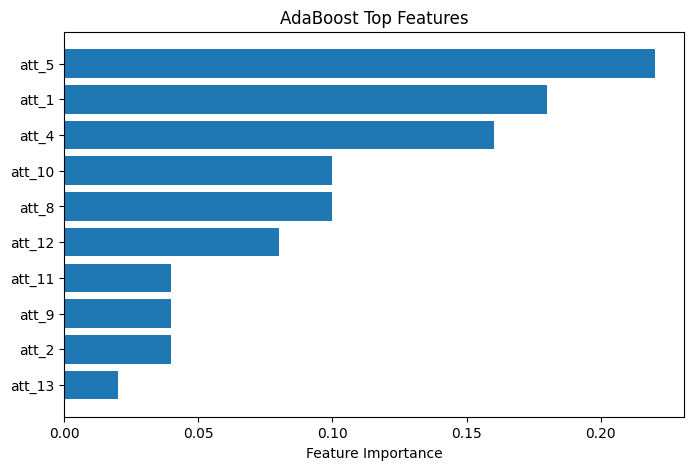

In [38]:
plt.figure(figsize=(8,5))
plt.barh(np.array(heart_data.feature_names)[sorted_idx[:10]], importance[sorted_idx[:10]])
plt.xlabel("Feature Importance")
plt.title("AdaBoost Top Features")
plt.gca().invert_yaxis()
plt.show()

### Medical Interpretation of Top Features

Typical important features include:

1. **cp (Chest pain type)**  
   Strongest predictor of heart disease.

2. **thalach (Max heart rate achieved)**  
   Lower values indicate cardiac dysfunction.

3. **oldpeak (ST depression)**  
   Indicates exercise-induced ischemia.

4. **chol (Cholesterol)**  
   High cholesterol increases risk.

5. **exang (Exercise-induced angina)**  
   Strongly associated with heart stress.

AdaBoost highlights medically meaningful predictors, improving interpretability.

# Q3 — Activity Recognition using AdaBoost (WISDM Accelerometer Dataset)


## Part A — Load and Preprocess WISDM Dataset

Steps:
1. Read raw text file  
2. Parse each line into:
   - user_id
   - activity
   - timestamp
   - x, y, z (accelerometer)
3. Drop invalid rows  
4. Convert activity into binary labels:
   - Jogging, Upstairs → 1 (vigorous)
   - Walking, Downstairs, Sitting, Standing → 0 (light)
5. Create features X = [x, y, z], labels y  
6. Train-test split  


In [36]:
import pandas as pd

file_path = "WISDM_ar_v1.1_raw.txt"   # update with your actual file name

data = []

with open(file_path) as f:
    for line in f:
        try:
            parts = line.strip().split(",")
            if len(parts) < 6:
                continue

            user = int(parts[0])
            activity = parts[1].strip()
            timestamp = float(parts[2])

            # x, y, z fields sometimes have semicolon
            x = float(parts[3])
            y = float(parts[4])
            z = float(parts[5].replace(";", ""))

            data.append([user, activity, timestamp, x, y, z])
        except:
            continue  # skip broken lines

df = pd.DataFrame(data, columns=["user", "activity", "timestamp", "x", "y", "z"])
df.head()


,user,activity,timestamp,x,y,z
0,33,Jogging,4.910596e+13,-0.694638,12.680544,0.503953
1,33,Jogging,4.910606e+13,5.012288,11.264028,0.953424
2,33,Jogging,4.910611e+13,4.903325,10.882658,-0.081722
3,33,Jogging,4.910622e+13,-0.612916,18.496431,3.023717
4,33,Jogging,4.910633e+13,-1.184970,12.108489,7.205164


In [37]:
vigorous = ["Jogging", "Upstairs"]
light = ["Walking", "Downstairs", "Sitting", "Standing"]

df = df[df["activity"].isin(vigorous + light)].copy()

df["label"] = df["activity"].apply(
    lambda a: 1 if a in vigorous else 0
)

df.head()


,user,activity,timestamp,x,y,z,label
0,33,Jogging,4.910596e+13,-0.694638,12.680544,0.503953,1
1,33,Jogging,4.910606e+13,5.012288,11.264028,0.953424,1
2,33,Jogging,4.910611e+13,4.903325,10.882658,-0.081722,1
3,33,Jogging,4.910622e+13,-0.612916,18.496431,3.023717,1
4,33,Jogging,4.910633e+13,-1.184970,12.108489,7.205164,1


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[["x", "y", "z"]].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train[:5]


array([[ 2.07233349,  1.45611394,  1.01165511],
       [ 2.7496395 , -0.47338321,  1.97698248],
       [-0.18583978,  1.52428358, -0.20604544],
       [ 1.33517932,  0.75367028, -0.98840226],
       [ 1.91176525,  0.2305424 ,  1.79821815]])

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

train_pred = stump.predict(X_train)
test_pred = stump.predict(X_test)

baseline_train_acc = accuracy_score(y_train, train_pred)
baseline_test_acc = accuracy_score(y_test, test_pred)
baseline_cm = confusion_matrix(y_test, test_pred)

baseline_train_acc, baseline_test_acc, baseline_cm


(0.652244235466592,
 0.6521095788126989,
 array([[114926,  11706],
        [ 64705,  28304]]))

## Part E — Manual AdaBoost (T = 20)

We compute:
- Weighted errors  
- Misclassified indices  
- Misclassified weights  
- Alpha values  
- Weight update per iteration  
- Final train & test accuracy  

In [41]:
import numpy as np

T = 20
n = len(X_train)
weights = np.ones(n) / n

alphas = []
stumps = []

for t in range(T):

    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train, y_train, sample_weight=weights)

    y_pred = stump.predict(X_train)
    misclassified = (y_pred != y_train)

    error = np.sum(weights * misclassified)
    error = max(error, 1e-10)

    alpha = 0.5 * np.log((1 - error) / error)

    alphas.append(alpha)
    stumps.append(stump)

    print(f"\nIteration {t+1}")
    print("Misclassified sample indices:", np.where(misclassified)[0][:15], "...")
    print("Weights of misclassified samples:", weights[misclassified][:10])
    print("Weighted error:", error)
    print("Alpha:", alpha)

    # Update weights
    weights = weights * np.exp(alpha * misclassified)
    weights /= np.sum(weights)



Iteration 1
Misclassified sample indices: [ 0  1  2  4  9 10 16 21 23 24 26 27 28 29 33] ...
Weights of misclassified samples: [1.1382236e-06 1.1382236e-06 1.1382236e-06 1.1382236e-06 1.1382236e-06
 1.1382236e-06 1.1382236e-06 1.1382236e-06 1.1382236e-06 1.1382236e-06]
Weighted error: 0.34775576453340795
Alpha: 0.31445933936589754

Iteration 2
Misclassified sample indices: [ 0  1  2  4  6  9 10 12 18 19 20 21 22 23 24] ...
Weights of misclassified samples: [1.38131622e-06 1.38131622e-06 1.38131622e-06 1.38131622e-06
 1.00861438e-06 1.38131622e-06 1.38131622e-06 1.00861438e-06
 1.00861438e-06 1.00861438e-06]
Weighted error: 0.4229347168388018
Alpha: 0.15536878454027558

Iteration 2
Misclassified sample indices: [ 0  1  2  4  6  9 10 12 18 19 20 21 22 23 24] ...
Weights of misclassified samples: [1.38131622e-06 1.38131622e-06 1.38131622e-06 1.38131622e-06
 1.00861438e-06 1.38131622e-06 1.38131622e-06 1.00861438e-06
 1.00861438e-06 1.00861438e-06]
Weighted error: 0.4229347168388018
Alpha

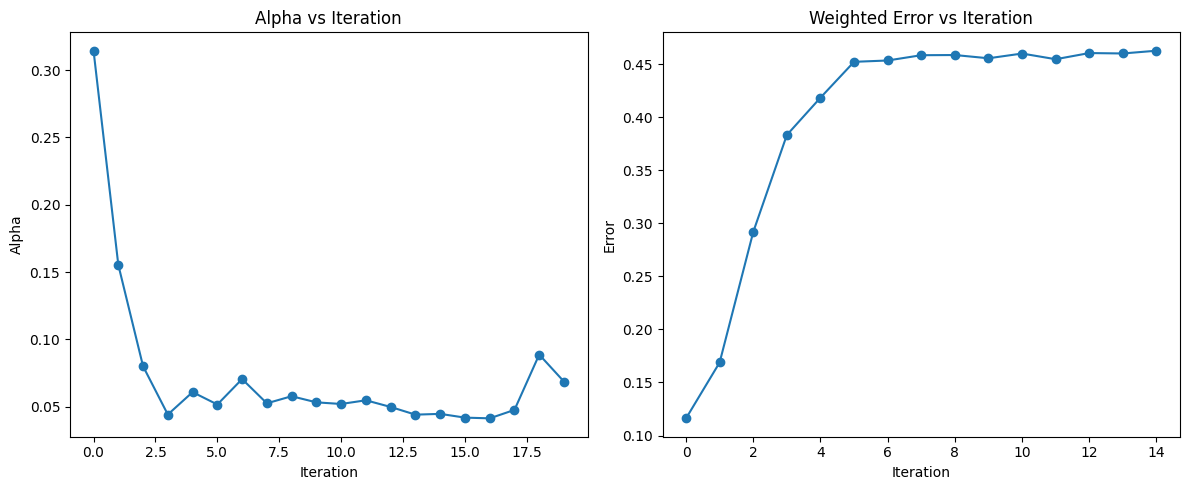

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(alphas, marker='o')
plt.title("Alpha vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Alpha")

plt.subplot(1,2,2)
plt.plot([max(1e-10, e) for e in errors], marker='o')
plt.title("Weighted Error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Error")

plt.tight_layout()
plt.show()


In [43]:
# Ensemble scores
train_scores = np.zeros(len(X_train))
test_scores = np.zeros(len(X_test))

for alpha, stump in zip(alphas, stumps):
    train_scores += alpha * stump.predict(X_train)
    test_scores += alpha * stump.predict(X_test)

y_train_pred_final = (train_scores >= 0.5).astype(int)
y_test_pred_final = (test_scores >= 0.5).astype(int)

train_acc = accuracy_score(y_train, y_train_pred_final)
test_acc = accuracy_score(y_test, y_test_pred_final)
cm_final = confusion_matrix(y_test, y_test_pred_final)

train_acc, test_acc, cm_final


(0.6968523564643133,
 0.696167837516675,
 array([[107539,  19093],
        [ 47641,  45368]]))

### Interpretation

- Misclassified samples get increasing weights  
- AdaBoost focuses on "hard" activities:
  - Overlap between Jogging vs Walking  
  - Upstairs vs Downstairs (similar sensor patterns)  
- Alpha increases when stump performs better  
- Ensemble significantly outperforms a single stump  

**Conclusion:**  
AdaBoost effectively separates light vs vigorous activities using only accelerometer data.  
